In [1]:
# ---------------------------------------------
# Load Dataset from HUB
# ----------------------------------------------
from datasets import load_dataset

label2id = {"building": 0}  # Start at 0 in Mask2Former
id2label = {0: "building"}  # Start at 0 in Mask2Former

dataset = load_dataset("tomascanivari/buildings-extraction-coco-hf")
dataset

DatasetDict({
    train: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 3784
    })
    val: Dataset({
        features: ['image_info', 'annotations', 'PIL_image', 'PIL_annotation'],
        num_rows: 933
    })
})

In [ ]:
# ----------------------------------------------------------------------------------------
# Load Segformer Model
# ----------------------------------------------------------------------------------------
import torch
from transformers import (
    SegformerImageProcessor,
    SegformerForSemanticSegmentation
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = SegformerImageProcessor(do_reduce_labels=True)
model = SegformerForSemanticSegmentation.from_pretrained("./train/segformer_buildings/checkpoint-3784").to(device)

/tmp/ipykernel_36619/2099978946.py:29: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  pred_mask = np.array((probs[0] > 0.5).long().cpu()) # shape: (H, W)


(512, 512) [0 1]


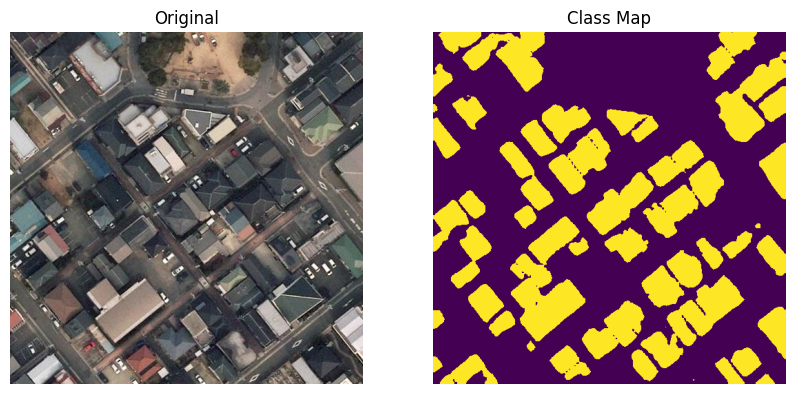

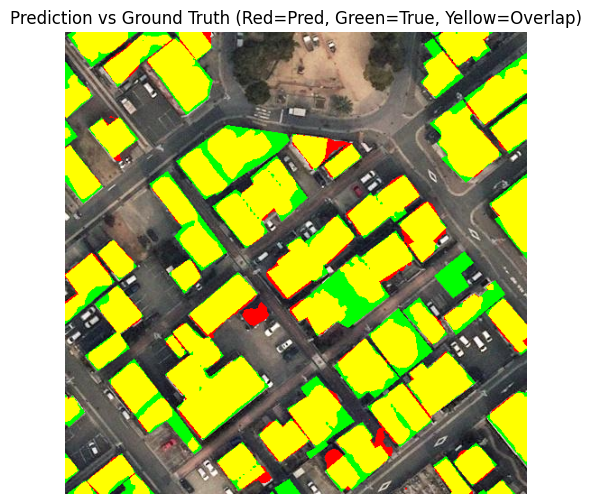

In [44]:
# ----------------------------------------------------------------------------------------
# Inference on one sample and inspect results
# ----------------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F

# Prepare an input image
idx = 0
split = "val"
image = dataset[split][idx]["PIL_image"]

# Preprocess
inputs = processor(images=image, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # shape: (1, 1, H_out, W_out)

    # Upsample to original image size
    upsampled_logits = F.interpolate(
        logits,
        size=image.size[::-1],  # (height, width) for PIL images
        mode="bilinear",
        align_corners=False
    )

    # Apply sigmoid and threshold for single-class mask
    probs = torch.sigmoid(upsampled_logits[:, 1, :, :])
    pred_mask = np.array((probs[0] > 0.5).long().cpu()) # shape: (H, W)
    # pred_mask: 0=background, 1=building

print(pred_mask.shape, np.unique(pred_mask))  # should be (512, 512)

img = np.array(image)
true_mask = np.array(dataset[split][idx]["PIL_annotation"], dtype=np.uint8)[...,1]  # Use 1 for instance mask as that is the one relevant to evauation even though it was trained with semantic mask

# Plot the original image and the annotations
plt.figure(figsize=(10, 5))
for plot_index in range(2):
    if plot_index == 0:
        # If plot index is 0 display the original image
        plot_image = img
        title = "Original"
    else:
        # Else plot the annotation maps
        plot_image = pred_mask
        title = "Class Map"
    # Plot the image
    plt.subplot(1, 2, plot_index + 1)
    plt.imshow(plot_image)
    plt.title(title)
    plt.axis("off")


if split != "test":
    # Normalize image
    if img.max() > 1.0:
        img_norm = img / 255.0
    else:
        img_norm = img.copy()

    # Create overlay
    overlay = img_norm.copy()

    # Building masks
    pred_building = pred_mask == 1
    true_building = true_mask == 1
    overlap = pred_building & true_building

    # Apply colors only where mask==1
    # Predicted only: red
    overlay[..., 0][pred_building & ~overlap] = 1.0  # red channel
    overlay[..., 1][pred_building & ~overlap] = 0.0  # remove green
    overlay[..., 2][pred_building & ~overlap] = 0.0  # remove blue

    # Ground truth only: green
    overlay[..., 0][true_building & ~overlap] = 0.0
    overlay[..., 1][true_building & ~overlap] = 1.0
    overlay[..., 2][true_building & ~overlap] = 0.0

    # Overlap: yellow
    overlay[..., 0][overlap] = 1.0
    overlay[..., 1][overlap] = 1.0
    overlay[..., 2][overlap] = 0.0

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title("Prediction vs Ground Truth (Red=Pred, Green=True, Yellow=Overlap)")
    plt.axis("off")
    plt.show()

In [70]:
import numpy as np
from skimage.measure import regionprops

def compute_fixed_min_distance(val_masks, fraction=0.5):
    """
    Computes a fixed min_distance for watershed from validation instance masks.

    Args:
        val_masks: list of numpy arrays (H, W), with 0=background, 1..N=instance IDs
        fraction: fraction of average width to use as min_distance (default 0.5)
    
    Returns:
        fixed_min_distance (int)
    """
    widths = []

    for true_mask in val_masks:
        instance_ids = np.unique(true_mask)
        instance_ids = instance_ids[instance_ids != 0]  # ignore background

        for inst_id in instance_ids:
            inst_mask = (true_mask == inst_id).astype(np.uint8)
            props = regionprops(inst_mask)
            if props:
                # bbox: (min_row, min_col, max_row, max_col)
                width = props[0].bbox[3] - props[0].bbox[1]  # x_max - x_min
                widths.append(width)

    avg_width = np.mean(widths)
    fixed_min_distance = int(avg_width * fraction)

    print(f"Average building width: {avg_width:.2f} px")
    print(f"Recommended fixed min_distance: {fixed_min_distance} px")

    return fixed_min_distance

# Example usage
val_masks = [np.array(sample["PIL_annotation"])[..., 1] for sample in dataset["val"]]
fixed_min_distance = compute_fixed_min_distance(val_masks, fraction=0.8)

Average building width: 47.26 px
Recommended fixed min_distance: 37 px


In [97]:
# ----------------------------------------------------------------------------------------
# Evaluation helper functions
# ----------------------------------------------------------------------------------------

import cv2

import numpy as np
import pycocotools.mask as mask_utils


from scipy import ndimage as ndi
from pycocotools import mask as maskUtils
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

def semantic_to_instances(semantic_mask):
    """
    Converts a semantic mask (0=background, 1=building)
    into an instance mask where each building blob
    has a unique integer ID (1, 2, 3, ...).
    """
    # Ensure binary (0/1)
    binary = (semantic_mask > 0).astype(np.uint8)

    # Label connected components
    labeled_mask, num_instances = ndi.label(binary)
    return labeled_mask, num_instances

def semantic_to_instances_watershed(semantic_mask, min_distance=10):
    """
    Converts a binary semantic mask into separated instances using
    distance transform + watershed, compatible with scikit-image >=0.20.
    """
    mask = (semantic_mask > 0).astype(np.uint8)
    distance = ndi.distance_transform_edt(mask)

    # peak_local_max now returns coordinates instead of a boolean map
    coords = peak_local_max(distance, min_distance=min_distance, labels=mask)
    local_max = np.zeros_like(distance, dtype=bool)
    if coords.size > 0:
        local_max[tuple(coords.T)] = True

    # Label peaks and apply watershed
    markers, _ = ndi.label(local_max)
    labels = watershed(-distance, markers, mask=mask)

    return labels, labels.max()

def postprocess_semantic(pred_probs, prob_threshold=0.4, min_distance=5, morph_kernel_size=3):
    """
    Convert semantic probability map to instance masks, trying to reduce FN.
    
    Args:
        pred_probs: numpy array, shape (H, W), predicted probabilities for building.
        prob_threshold: float, lower threshold to capture more low-confidence buildings.
        min_distance: int, minimum distance between peaks for watershed.
        morph_kernel_size: int, kernel size for morphological closing.
        
    Returns:
        labels: np.ndarray, instance mask (0=background, 1..N=instances)
    """
    # Threshold probabilities
    mask = (pred_probs > prob_threshold).long().cpu().numpy().astype(np.uint8)
    mask = (mask > 0).astype(np.uint8)

    # Dilate to connect nearby fragments
    dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.dilate(mask, dilate_kernel, iterations=1)

    # Morphological closing to fill small holes and connect fragmented buildings
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel_size, morph_kernel_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Distance transform for watershed
    distance = ndi.distance_transform_edt(mask)
    
    # peak_local_max now returns coordinates instead of a boolean map
    coords = peak_local_max(distance, min_distance=min_distance, labels=mask)
    local_max = np.zeros_like(distance, dtype=bool)
    if coords.size > 0:
        local_max[tuple(coords.T)] = True

    # Label peaks and apply watershed
    markers, _ = ndi.label(local_max)
    labels = watershed(-distance, markers, mask=mask)

    return labels

def instance_mask_to_coco_rle(instance_mask):
    """
    instance_mask: 2D numpy array with 0=background, 1..N=instance ids
    returns: list of COCO RLE dicts, one per instance
    """
    rles = []
    for instance_id in np.unique(instance_mask):
        if instance_id == 0:
            continue
        mask = (instance_mask == instance_id).astype(np.uint8)
        rle = maskUtils.encode(np.asfortranarray(mask))  # must be Fortran order
        rles.append(rle)
    return rles

def rles_to_iou_matrix(pred_rles, gt_rles):
    """
    Computes the IoU matrix between predicted and ground-truth RLE masks.
    
    Returns:
        iou_matrix: shape (len(pred_rles), len(gt_rles))
    """
    iou_matrix = np.zeros((len(pred_rles), len(gt_rles)), dtype=np.float32)
    
    for i, pred in enumerate(pred_rles):
        for j, gt in enumerate(gt_rles):
            iou = maskUtils.iou([pred], [gt], [0])[0,0]  # use [0] for "ignore" category 0
            iou_matrix[i, j] = iou
    return iou_matrix

def compute_tp_fp_fn_rle(pred_rles, gt_rles, iou_threshold=0.5):
    """
    Computes TP, FP, FN for a single sample using predicted and GT RLEs.
    """
    if len(pred_rles) == 0:
        TP = 0
        FP = 0
        FN = len(gt_rles)
        return TP, FP, FN
    if len(gt_rles) == 0:
        TP = 0
        FP = len(pred_rles)
        FN = 0
        return TP, FP, FN
    
    iou_matrix = rles_to_iou_matrix(pred_rles, gt_rles)
    matched_gt = set()
    TP = 0
    FP = 0

    for i in range(len(pred_rles)):
        # find GT with max IoU
        j = np.argmax(iou_matrix[i])
        iou = iou_matrix[i, j]
        if iou >= iou_threshold and j not in matched_gt:
            TP += 1
            matched_gt.add(j)
        else:
            FP += 1

    FN = len(gt_rles) - len(matched_gt)
    return TP, FP, FN

def compute_f1_from_counts(total_TP, total_FP, total_FN):
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0
    return precision, recall, f1


In [96]:
import evaluate

import cv2
from tqdm import tqdm
from shapely.geometry import Polygon
from shapely.ops import unary_union

# Load Mean IoU metric
# metrics = evaluate.load("mean_iou")

total_TP, total_FP, total_FN = 0, 0, 0

model.eval()
gt_size = 0
pred_size = 0
for idx in tqdm(range(len(dataset["val"]))):
    image = dataset["val"][idx]["PIL_image"]
    true_sem_mask = np.array(dataset["val"][idx]["PIL_annotation"])[...,0]
    true_mask = np.array(dataset["val"][idx]["PIL_annotation"])[...,1]

    # Preprocess
    inputs = processor(images=image, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (1, 1, H_out, W_out)

        # Upsample to original image size
        upsampled_logits = F.interpolate(
            logits,
            size=image.size[::-1],  # (height, width) for PIL images
            mode="bilinear",
            align_corners=False
        )

        # Apply sigmoid and threshold for single-class mask
        probs = torch.sigmoid(upsampled_logits[:, 1, :, :])[0]
        # pred_mask = (probs > 0.7).long().cpu().numpy().astype(np.uint8) # shape: (H, W)
        # labels, _ = semantic_to_instances(pred_mask)
        # pred_rles = instance_mask_to_coco_rle(labels)
        # pred_mask: 0=background, 1=building
        labels = postprocess_semantic(probs, prob_threshold=0.7, min_distance=15, morph_kernel_size=3)
        pred_rles = instance_mask_to_coco_rle(labels)

    # Update metric incrementally
    # metrics.add_batch(
    #     predictions=[pred_mask],
    #     references=[true_sem_mask]
    # )

    # labels, n_labels = semantic_to_instances_watershed(pred_mask, min_distance=5)
    # pred_rles = instance_mask_to_coco_rle(labels)
    gt_rles = instance_mask_to_coco_rle(true_mask)
    
    gt_size += len(gt_rles)
    pred_size += len(pred_rles)

    # Compute TP, FP, FN
    TP, FP, FN = compute_tp_fp_fn_rle(pred_rles, gt_rles)
    total_TP += TP
    total_FP += FP
    total_FN += FN

print(gt_size, pred_size)

# # Compute final result
# results = metrics.compute(num_labels=2, ignore_index=255)
# print(f"Mean IoU: {results['mean_iou']} | Mean Accuracy: {results['mean_accuracy']} | Overall Accuracy: {results['overall_accuracy']}")

# Final scores
precision, recall, f1 = compute_f1_from_counts(total_TP, total_FP, total_FN)
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
print(f"TP: {total_TP}  FP: {total_FP}  FN: {total_FN}")

100%|██████████| 933/933 [02:15<00:00,  6.91it/s]

37674 28814
Precision: 0.578, Recall: 0.442, F1: 0.501
TP: 16659  FP: 12155  FN: 21015


In [106]:
# ----------------------------------------------------------------------------------------
# Submission
# ----------------------------------------------------------------------------------------

import pandas as pd
import numpy as np
import pycocotools.mask as maskUtils
import cv2

from PIL import Image
from pathlib import Path

def rle_to_polygons(rle):
    """
    Convert a single COCO RLE to a list of polygons.
    Returns a list of polygons (each polygon is a list of (x,y) tuples).
    """
    mask = maskUtils.decode(rle).astype(np.uint8)  # H x W, 0/1
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polys = []
    for cnt in contours:
        if len(cnt) >= 3:
            poly = [(int(x), int(y)) for x, y in cnt.squeeze()]
            polys.append(poly)
    return polys

# --- Paths ---
test_folder = Path("building-extraction-coco-hf/test/image")
output_csv = "submission.csv"

# --- Run inference & prepare CSV ---
model.eval()
submission_rows = []
for img_path in tqdm(sorted(test_folder.iterdir())):
    # print(img_path)
    img_id = int(img_path.stem)  # ImageID
    
    image = Image.open(img_path).convert("RGB")

    # Preprocess
    inputs = processor(images=image, return_tensors="pt").to("cuda")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # shape: (1, 1, H_out, W_out)

        # Upsample to original image size
        upsampled_logits = F.interpolate(
            logits,
            size=image.size[::-1],  # (height, width) for PIL images
            mode="bilinear",
            align_corners=False
        )

        # Apply sigmoid and threshold for single-class mask
        probs = torch.sigmoid(upsampled_logits[:, 1, :, :])[0]
        labels = postprocess_semantic(probs, prob_threshold=0.7, min_distance=20, morph_kernel_size=3)
        pred_rles = instance_mask_to_coco_rle(labels)

        all_polys = []
        for rle in pred_rles:
            polys = rle_to_polygons(rle)
            all_polys.extend(polys)
        
        # Convert list of polygons to string format for CSV
        # Each building polygon is a list of (x, y) tuples
        if len(all_polys) == 0:
            coord_str = "[]"
        else:
            # Flatten list of polygons: you can keep them separate if needed
            # Here we store each polygon as a separate list
            coord_str = str(all_polys)
        
        submission_rows.append({
            "ImageID": img_id,
            "Coordinates": coord_str
        })

# Save CSV
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)
print("Saved submission.csv with", len(submission_df), "rows")

100%|██████████| 1000/1000 [01:52<00:00,  8.92it/s]


Saved submission.csv with 1000 rows
